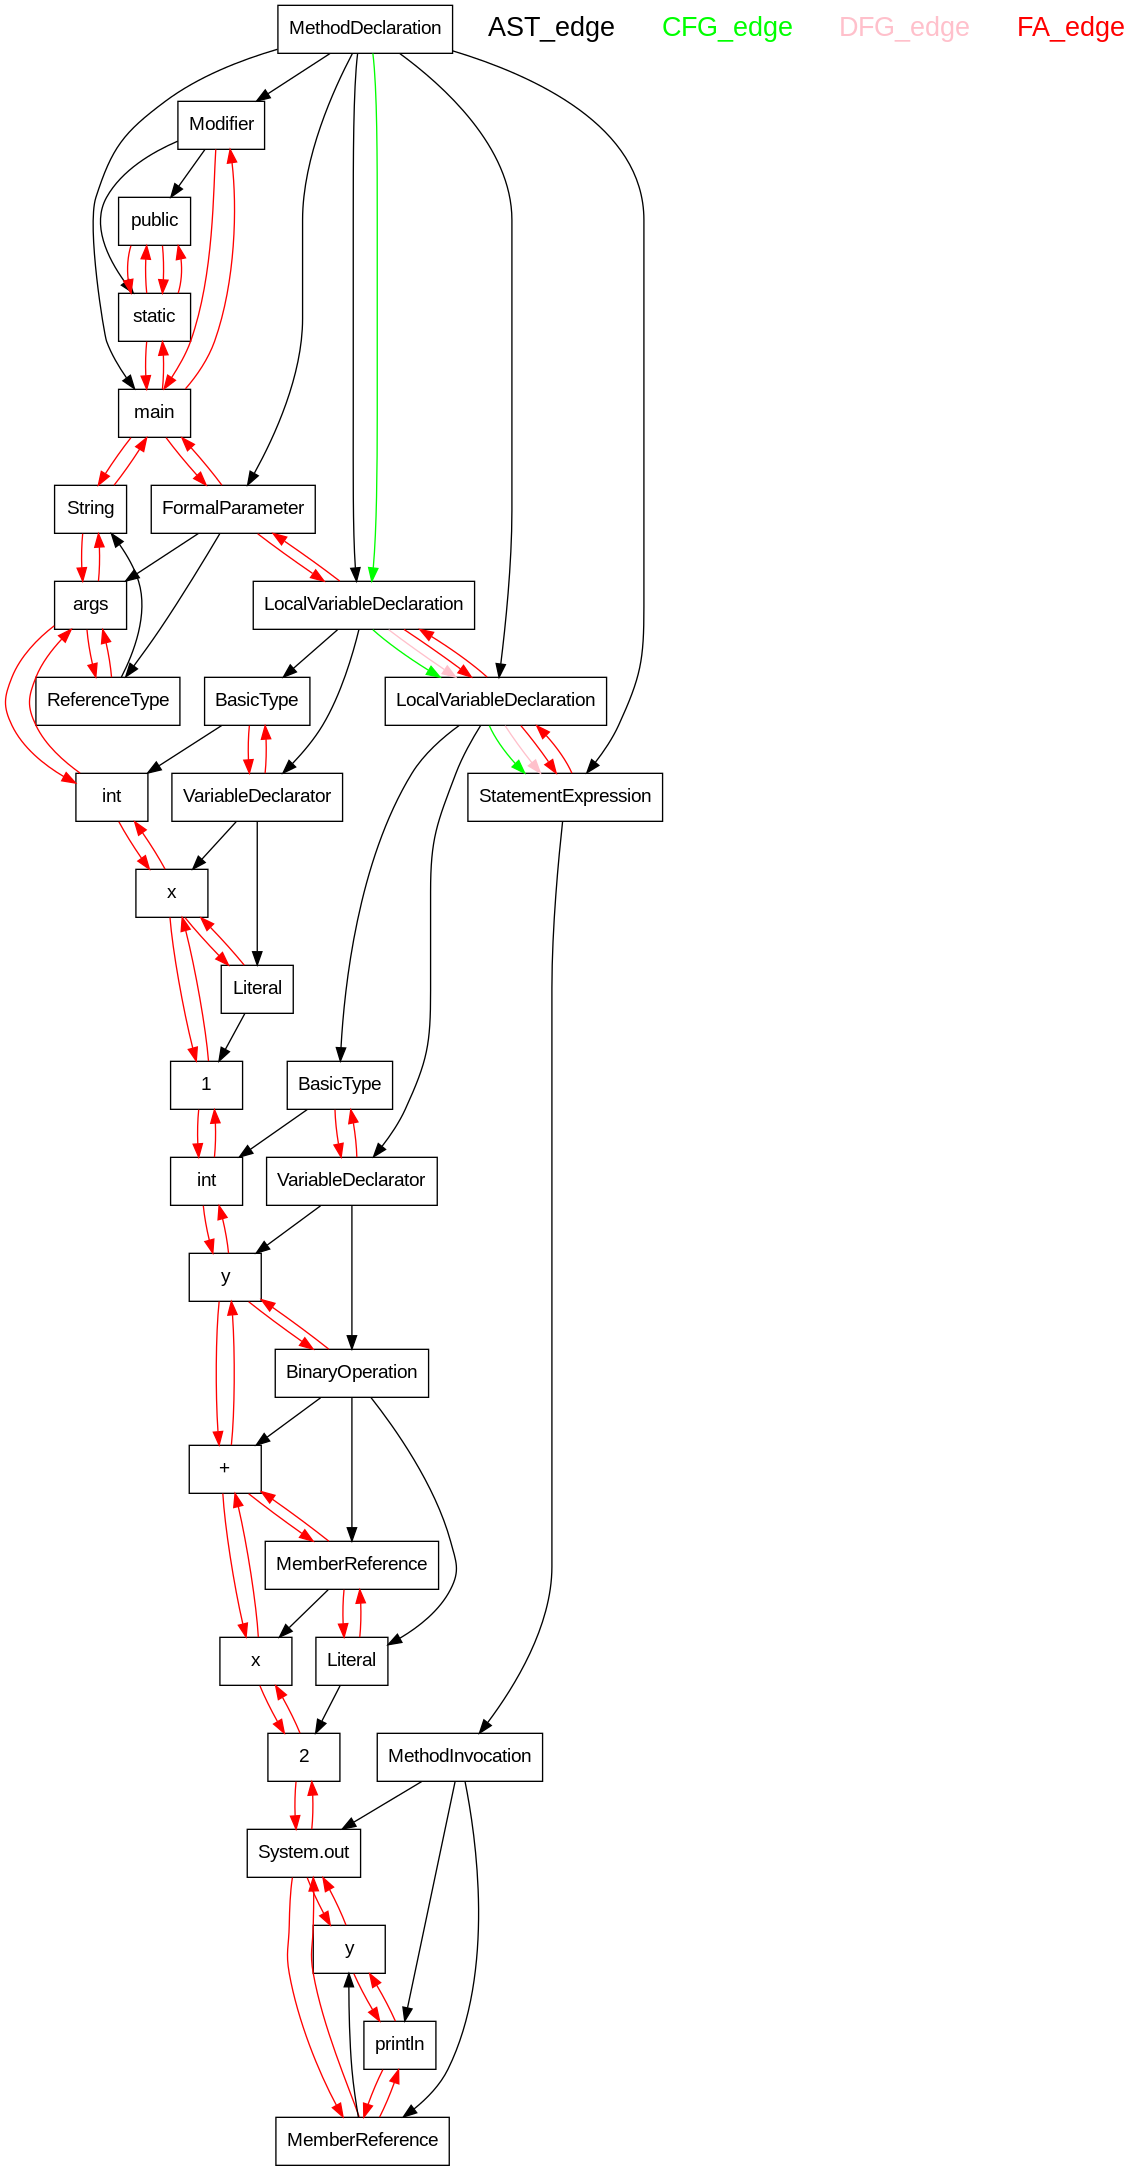

In [1]:
import os
import javalang
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from data.sast.java_2.ast_api import get_sequence
from anytree import AnyNode
from data.sast.java_2.ast_api import createtree
from data.graph_builder.ast_builder import get_ast_edge
from data.graph_builder.cfg_builder import get_cfg_edge
from data.graph_builder.dfg_builder import get_dfg_edge
from data.graph_builder.fa_builder import get_if_edge, get_loops_edge, get_next_sib_edge, get_next_use_edge, get_next_token_edge


# file_path = '/home/zixian/PycharmProjects/Multigraph_match/data/data_source/dataset_bigclonebench/dataset_files/13725738.java'

file_path = '/home/zixian/PycharmProjects/semantic_graph_code_code_clone/visual/test.java'

alltokens=[]

programfile=open(os.path.join(file_path),encoding='utf-8')

programtext=programfile.read()
programtokens=javalang.tokenizer.tokenize(programtext)
parser=javalang.parse.Parser(programtokens)
programast=parser.parse_member_declaration()


get_sequence(programast,alltokens)
alltokens=list(set(alltokens))
vocabsize = len(alltokens)
tokenids = range(vocabsize)
vocabdict = dict(zip(alltokens, tokenids))

# create graph

nodelist = []
newtree = AnyNode(id=0, token=None, data=None, is_statement=False)
createtree(newtree, programast, nodelist)
x = []
edgesrc = []
edgetgt = []
edge_attr = []
get_ast_edge(newtree, x, vocabdict, edgesrc, edgetgt, edge_attr)


get_cfg_edge(newtree, edgesrc, edgetgt, edge_attr)

newtree, edgesrc, edgetgt, edge_attr = get_dfg_edge(newtree, edgesrc, edgetgt, edge_attr)


get_if_edge(newtree, edgesrc, edgetgt, edge_attr)

get_loops_edge(newtree, edgesrc, edgetgt, edge_attr)

get_next_sib_edge(newtree, edgesrc, edgetgt, edge_attr)

tokenlist=[]
get_next_token_edge(newtree, edgesrc, edgetgt, edge_attr, tokenlist)
variabledict={} 
get_next_use_edge(newtree, edgesrc, edgetgt, edge_attr, variabledict)


from anytree import Node, RenderTree
from graphviz import Digraph
from IPython.display import Image, display


def extract_node_edges(root):
    node_dict = {}
    for _, _, node in RenderTree(root):
        node_dict[node.id] = node
    return node_dict


def add_nodes_edges(graph, node_dict, edgesrc, edgetgt, edge_attr):

    color_map = {
        'AST_edge': 'black',
        'CFG_edge': 'green',
        'DFG_edge': 'pink',
        'FA_edge': 'red',
    }

    edge_type_map = {
        0: 'black',
        1: 'black',
        2: 'green',
        3: 'pink',
        4: 'red',
        5: 'red',
        6: 'red',
        7: 'red'
    }

    for node_id, node_obj in node_dict.items():


        graph.node(str(node_id), label=node_obj.token if node_obj.token else 'Unknown')
        # graph.node(str(node_id), label=node_obj.token + "-" + str(node_id)  if node_obj.token else 'Unknown')


    for i in range(len(edgesrc)):
        scr_node = node_dict.get(edgesrc[i])
        tgt_node = node_dict.get(edgetgt[i])
        if scr_node and tgt_node:
            edge_color = edge_type_map[edge_attr[i][0][0]]
            graph.edge(str(scr_node.id), str(tgt_node.id), color=edge_color)
    
    with graph.subgraph(name="legend") as s:
        s.attr(label='Legend', style='dashed')
        for edge_type_name, edge_color in color_map.items():
            s.node(edge_type_name, label=edge_type_name, shape='plaintext', fontcolor=edge_color, fontsize="20")  


g = Digraph('AST', filename='ast_tree.gv', format='png', node_attr={'shape': 'box', 'fontname': 'Arial'})

add_nodes_edges(g, extract_node_edges(newtree), edgesrc, edgetgt, edge_attr)

g.render(filename='ast_tree', cleanup=False)  # writes ast_tree.png
display(Image(filename='ast_tree.png'))